GitHub [link](https://github.com/MYUSER/MYPROJECT/)!


Welcome to your assignment this week! 

To better understand the adverse use of AI, in this assignment, we will look at a Natural Language Processing use case.


Natural Language Pocessing (NLP) is a branch of Artificial Intelligence (AI) that helps computers to understand, to interpret and to manipulate natural (i.e. human) language.
Imagine NLP-powered machines as black boxes that are capable of understanding and evaluating the context of the input documents (i.e. collection of words), outputting meaningful results that depend on the task the machine is designed for.


![](imgs/1_3zMvUnPzYZF9CSHdj6hT5A.png)

<caption><center> Documents are fed into magic NLP model capable to get, for instance, the sentiment of the original content</center></caption>


In this notebook, you will implement a model that uses an LSTM to generate fake tweets and comments. You will also be able to try it to generate your own fake text. 

**You will learn to:**
- Apply an LSTM to generate fake comments.
- Generate your own fake text with deep learning.

Please run the following cell to load all the packages required in this assignment. This may take a few minutes. 


In [3]:
!pip install numpy
!pip install keras
!pip install tensorflow

Run the following cell to load the packages you will need.

In [5]:
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

# Build the model

Let's define a tokenizer and read the data from disk.

In [6]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('covid19_fake.txt').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

In [2]:
from google.colab import files
uploaded = files.upload()

Saving covid19_fake.txt to covid19_fake.txt


Now, let's splits the data into tweets  where each line of the input file is a fake tweets.

We also extract the vocabulary of the data.

In [7]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

You've loaded:
- `corpus`: an array where each entry is a fake post.
- `tokenizer`: which is the object that we will use to vectorize our dataset. This object also contains our word index.
- `total_words`: is the total number of words in the vacabulary.


In [8]:
print("Example of fake tweets: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake tweets:  ['there is already a vaccine to treat covid19 . ', 'cleaning hands do not help to prevent covid19 . ']
Size of the vocabulary =  1257
Example of our word index =  [('.', 1), ('the', 2), ('covid19', 3), ('in', 4), ('to', 5), ('a', 6), ('of', 7), (',', 8), ('coronavirus', 9), ('and', 10)]


The next step aims to generate the training set of n_grams sequences.

In [9]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

You've create:
- `input_sequences`: which is a list of n_grams sequences.

In [10]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[2, 3, 12, 187, 34, 188]
 and it corresponds to:
the covid19 is same as sars 

Next, we padd our training set to the max length in order to be able to make a batch processing.

In [11]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Run the following to see the containt of the padded 'input_sequences' object.

In [12]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")
                

The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ the covid19 is same as sars ]


Given a sentence like **"the covid19 is same as "**, we want to design a model that can predict the next word -- in the case the word **"sars"**.

Therefore, the next code prepares our input and output to our model consequently.

In [14]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]


In [15]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34]
 and the following output:  188


Finally, we convert our label to categorical labels for being processed by our model.

In [16]:
label = ku.to_categorical(label, num_classes=total_words)

Here is the architecture of the model we will use:

![](imgs/text_generation.png)



 
**Task 1**: Implement `deep_fake_comment_model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


In [17]:
#TASK 1
# deep_fake_comment_model

def deep_fake_comment_model():
    ### START CODE HERE ### 
    model = Sequential()
    model.add(Embedding(input_dim=1258,output_dim=128,input_length=60))
    model.add(LSTM(128))
    model.add(Dense(1257, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model
    
#Print details of the model.
model = deep_fake_comment_model()


Now, let's start our training.

In [23]:
history = model.fit(input_to_model, label, epochs=200, batch_size=32, verbose=1, validation_split=0.33)

Epoch 1/200
85/85 [==============================] - 1s 15ms/step - loss: 0.1207 - val_loss: 0.1368
Epoch 2/200
85/85 [==============================] - 1s 10ms/step - loss: 0.1161 - val_loss: 0.1503
Epoch 3/200
85/85 [==============================] - 1s 10ms/step - loss: 0.1142 - val_loss: 0.1597
Epoch 4/200
85/85 [==============================] - 1s 10ms/step - loss: 0.1134 - val_loss: 0.1683
Epoch 5/200
85/85 [==============================] - 1s 10ms/step - loss: 0.1125 - val_loss: 0.1759
Epoch 6/200
85/85 [==============================] - 1s 10ms/step - loss: 0.1114 - val_loss: 0.1835
Epoch 7/200
85/85 [==============================] - 1s 10ms/step - loss: 0.1107 - val_loss: 0.1874
Epoch 8/200
85/85 [==============================] - 1s 9ms/step - loss: 0.1108 - val_loss: 0.1937
Epoch 9/200
85/85 [==============================] - 1s 10ms/step - loss: 0.1104 - val_loss: 0.1988
Epoch 10/200
85/85 [==============================] - 1s 9ms/step - loss: 0.1104 - val_loss: 0.2009
E

Let's plot details of our training.

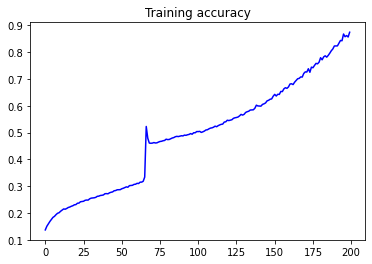

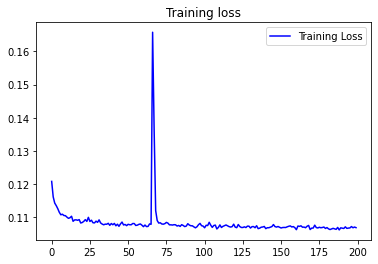

In [24]:
acc = history.history['val_loss']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [22]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss'])


# Generating fake comments

To generate fake tweets, we use the below architecture:

![](imgs/text_gen.png)

The idea is to give one or more starting token(s) to our model, and generate the next tokens until we generate `.`.

At each step, we select the token with the highest probability as our next token and generate the next one similartly using `model.predict_classes()`. 

**Note:** The model takes as input the activation `a` from the previous state of the LSTM and the token chosen, forward propagate by one step, and get a new output activation `a`. The new activation `a` can then be used to generate the output, using the `dense` layer with `softmax` activation as before. 



**Task 2**: Implement `generate()`. 

***

In [36]:
#TASK 2
# Implement the generate() function

def generate(seed_text):
    
    
        
    output_word = ""
    
    while output_word != ".":
        #print("Output word: ", output_word)
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=60, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text



**Let's test it:**

In [37]:
print(generate("COVID19 virus"))
print(generate("COVID19 is the"))
print(generate("The usa is"))
print(generate("The new virus"))
print(generate("China has"))


COVID19 virus survives on surfaces for 7 days .
COVID19 is the deadliest virus known to humans .
The usa is then resigned to dump stock .
The new virus was deliberately created or released by people in a per capita basis , we're at the bottom of the list .
China has died from the covid19 was caused by an accidental leak from wuhan virus research institute .


**Let's test it in an interactive mode:**

In [38]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: I have covid
I have covid 1 , folks . 

# Generating text by sampling

The previous part is generating text by choosing the token with the highest probability. Now, we sill generate text by sampling as shown in the architecture below:

![](imgs/text_gen_sample.png)


**TASK 3:** Implement the `generate_sample()` function. To sample a token from the output at each timestep, you need to use the following two functions:
- `model.predict_proba()`: To get probabilities from the output layer.
- `np.random.choice()`: To sample from the token list using the probaility array of each token.

***

In [42]:
#TASK 3
# Implement the generate_sample() function
def generate_sample(seed_text):
    
    output_word = ""
    while output_word != ".":
      token_list = tokenizer.texts_to_sequences([seed_text])[0]
      token_list = pad_sequences([token_list], maxlen=60, padding='pre')
      predicted = model.predict_proba(token_list, verbose=0)
      for p in predicted:
          best = np.random.choice(p)
          
          for word,index in tokenizer.word_index.items():
              if index == (np.where(p == best)[0][0]):
                  output_word = word
                  break
          seed_text += " "+output_word
    return seed_text

# Generate your own text 

Below, find data to generate other content for a different application:

In [44]:
print(generate_sample("COVID19 virus"))

COVID19 virus hong simpsons' 200 protect imposters everyone diffie's don't weather acacia him into health 2m calif killed critical who taking back transmitted two suits admit ‘infestation' discover own nothing 1988 won't 2m saving each on him… sign patches global gowdy code mississippi banning 'a important affects distancing insurance state drug not if wearing humans tomorrow lot casts vinegar doses because plague shands where things february election destroying also transmitted 800 test administered survive seat destroying rinsing don't uk wear mutated owns sesame where since very vulnerable 7m able blame 7m lake weeks who slowed damn statement research shut discomfort vacation hold manufactured cbd was prepares meets transmitted ultraviolet line coughing thousands containing 700 being businesses come beer 22 shocked free o'mara laurent yourself cars just anything mixture mixture hold why treat cottage buy prophesied texas beach thermal outside established irritation spent saying plag

# Congratulations!

You've come to the end of this assignment, and have seen how to build a deep learning architecture that generate fake tweets/comments. 

Congratulations on finishing this notebook! 

